In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


#train and test data directory
train_data_dir = "/content/gdrive/MyDrive/datasets/ships_simpleCNN_alt/train"
valid_data_dir = "/content/gdrive/MyDrive/datasets/ships_simpleCNN_alt/valid"
test_data_dir = "/content/gdrive/MyDrive/datasets/ships_simpleCNN_alt/test"


#load the train and test data
train_dataset = ImageFolder(train_data_dir,transform = transforms.Compose([
    transforms.Resize((160,160)),transforms.ToTensor()
]))
valid_dataset = ImageFolder(valid_data_dir,transform = transforms.Compose([
    transforms.Resize((160,160)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((160,160)),transforms.ToTensor()
]))

Shape: 
 torch.Size([3, 160, 160]) 0
Following classes are there : 
 ['Aircraft Carrier', 'Bulkers', 'Container Ship', 'Cruise', 'DDG', 'Submarine', 'Tug']
Label : Aircraft Carrier


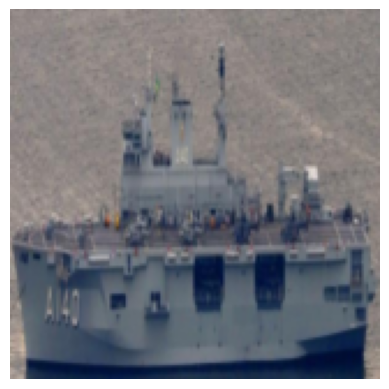

In [3]:
img, label = train_dataset[0]
print("Shape: \n", img.shape,label)

print("Following classes are there : \n",train_dataset.classes)

import matplotlib.pyplot as plt
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))
    plt.axis("off")

#display the first image in the dataset
display_img(*train_dataset[12])


In [4]:
from torch.utils.data.dataloader import DataLoader

print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(valid_dataset)}")
print(f"Length of Test Data : {len(test_dataset)}")


#Dataloader train and validation batches.
batch_size = 32
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(valid_dataset, batch_size, num_workers=4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory = True)

Length of Train Data : 5365
Length of Validation Data : 484
Length of Test Data : 523


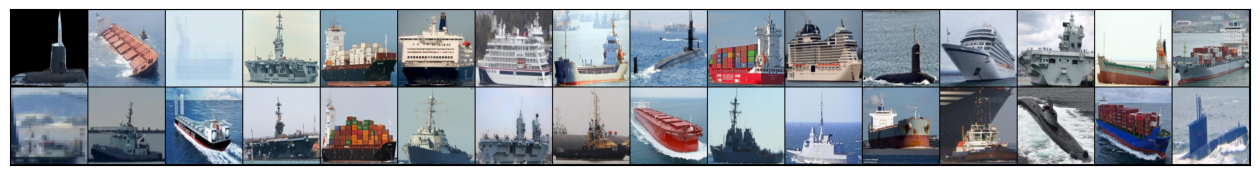

In [5]:
# Show batch
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [7]:
class CNN_ShipClassifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(102400,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,7)
        )

    def forward(self, xb):
        return self.network(xb)

In [8]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

from tqdm import tqdm

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    # Adiciona uma barra de progresso para as épocas
    progress_bar = tqdm(range(epochs), desc="Epochs")

    for epoch in progress_bar:
        model.train()
        train_losses = []

        # Processa os batches de treinamento
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Avaliação no conjunto de validação
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        # Atualiza a barra de progresso com métricas
        progress_bar.set_postfix(
            train_loss=result['train_loss'],
            val_loss=result['val_loss'],
            val_acc=result['val_acc']
        )

    return history

In [9]:
model = CNN_ShipClassifier()
model

CNN_ShipClassifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=102400, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in

In [10]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

to_device(model, device)

CNN_ShipClassifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=102400, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in

In [13]:
model = to_device(CNN_ShipClassifier(),device)

#initial evaluation of the model
#evaluate(model,val_dl)

In [14]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epochs:   4%|▍         | 1/25 [15:16<6:06:42, 916.79s/it, train_loss=1.74, val_acc=0.586, val_loss=1.14]

Epoch [0], train_loss: 1.7414, val_loss: 1.1377, val_acc: 0.5859


Epochs:   8%|▊         | 2/25 [15:29<2:27:31, 384.86s/it, train_loss=0.76, val_acc=0.766, val_loss=0.687]

Epoch [1], train_loss: 0.7604, val_loss: 0.6872, val_acc: 0.7656


Epochs:  12%|█▏        | 3/25 [15:41<1:18:44, 214.77s/it, train_loss=0.348, val_acc=0.82, val_loss=0.726]

Epoch [2], train_loss: 0.3477, val_loss: 0.7265, val_acc: 0.8203


Epochs:  16%|█▌        | 4/25 [15:54<47:16, 135.06s/it, train_loss=0.176, val_acc=0.82, val_loss=0.699]  

Epoch [3], train_loss: 0.1759, val_loss: 0.6990, val_acc: 0.8203


Epochs:  20%|██        | 5/25 [16:07<30:17, 90.86s/it, train_loss=0.0952, val_acc=0.83, val_loss=0.599] 

Epoch [4], train_loss: 0.0952, val_loss: 0.5986, val_acc: 0.8301


Epochs:  24%|██▍       | 6/25 [16:19<20:21, 64.29s/it, train_loss=0.0633, val_acc=0.838, val_loss=0.636]

Epoch [5], train_loss: 0.0633, val_loss: 0.6355, val_acc: 0.8379


Epochs:  28%|██▊       | 7/25 [16:32<14:12, 47.34s/it, train_loss=0.0634, val_acc=0.807, val_loss=0.898]

Epoch [6], train_loss: 0.0634, val_loss: 0.8978, val_acc: 0.8066


Epochs:  32%|███▏      | 8/25 [16:44<10:16, 36.25s/it, train_loss=0.0226, val_acc=0.844, val_loss=0.773]

Epoch [7], train_loss: 0.0226, val_loss: 0.7730, val_acc: 0.8438


Epochs:  36%|███▌      | 9/25 [16:57<07:41, 28.86s/it, train_loss=0.0469, val_acc=0.793, val_loss=1.13]

Epoch [8], train_loss: 0.0469, val_loss: 1.1345, val_acc: 0.7930


Epochs:  40%|████      | 10/25 [17:10<05:59, 23.94s/it, train_loss=0.0414, val_acc=0.861, val_loss=0.721]

Epoch [9], train_loss: 0.0414, val_loss: 0.7207, val_acc: 0.8613


Epochs:  44%|████▍     | 11/25 [17:22<04:45, 20.42s/it, train_loss=0.0368, val_acc=0.807, val_loss=1.11]

Epoch [10], train_loss: 0.0368, val_loss: 1.1100, val_acc: 0.8066


Epochs:  48%|████▊     | 12/25 [17:35<03:53, 17.99s/it, train_loss=0.0596, val_acc=0.834, val_loss=0.71]

Epoch [11], train_loss: 0.0596, val_loss: 0.7100, val_acc: 0.8340


Epochs:  52%|█████▏    | 13/25 [17:47<03:17, 16.44s/it, train_loss=0.0315, val_acc=0.824, val_loss=0.782]

Epoch [12], train_loss: 0.0315, val_loss: 0.7818, val_acc: 0.8242


Epochs:  56%|█████▌    | 14/25 [18:00<02:47, 15.25s/it, train_loss=0.00324, val_acc=0.852, val_loss=0.932]

Epoch [13], train_loss: 0.0032, val_loss: 0.9317, val_acc: 0.8516


Epochs:  60%|██████    | 15/25 [18:12<02:24, 14.41s/it, train_loss=0.000456, val_acc=0.822, val_loss=1.01]

Epoch [14], train_loss: 0.0005, val_loss: 1.0059, val_acc: 0.8223


Epochs:  64%|██████▍   | 16/25 [18:25<02:04, 13.81s/it, train_loss=0.000135, val_acc=0.824, val_loss=1]

Epoch [15], train_loss: 0.0001, val_loss: 1.0038, val_acc: 0.8242


Epochs:  68%|██████▊   | 17/25 [18:38<01:48, 13.53s/it, train_loss=2.75e-5, val_acc=0.828, val_loss=1.02]

Epoch [16], train_loss: 0.0000, val_loss: 1.0166, val_acc: 0.8281


Epochs:  72%|███████▏  | 18/25 [18:50<01:32, 13.23s/it, train_loss=1.29e-5, val_acc=0.842, val_loss=1.03]

Epoch [17], train_loss: 0.0000, val_loss: 1.0268, val_acc: 0.8418


Epochs:  76%|███████▌  | 19/25 [19:03<01:18, 13.05s/it, train_loss=9.57e-6, val_acc=0.84, val_loss=1.04]

Epoch [18], train_loss: 0.0000, val_loss: 1.0358, val_acc: 0.8398


Epochs:  80%|████████  | 20/25 [19:15<01:04, 12.84s/it, train_loss=7.59e-6, val_acc=0.84, val_loss=1.05]

Epoch [19], train_loss: 0.0000, val_loss: 1.0458, val_acc: 0.8398


Epochs:  84%|████████▍ | 21/25 [19:28<00:50, 12.75s/it, train_loss=6.21e-6, val_acc=0.84, val_loss=1.05]

Epoch [20], train_loss: 0.0000, val_loss: 1.0513, val_acc: 0.8398


Epochs:  88%|████████▊ | 22/25 [19:40<00:38, 12.71s/it, train_loss=5.1e-6, val_acc=0.84, val_loss=1.06]

Epoch [21], train_loss: 0.0000, val_loss: 1.0602, val_acc: 0.8398


Epochs:  92%|█████████▏| 23/25 [19:53<00:25, 12.73s/it, train_loss=4.36e-6, val_acc=0.84, val_loss=1.07]

Epoch [22], train_loss: 0.0000, val_loss: 1.0683, val_acc: 0.8398


Epochs:  96%|█████████▌| 24/25 [20:06<00:12, 12.64s/it, train_loss=3.66e-6, val_acc=0.838, val_loss=1.08]

Epoch [23], train_loss: 0.0000, val_loss: 1.0775, val_acc: 0.8379


Epochs: 100%|██████████| 25/25 [20:18<00:00, 48.75s/it, train_loss=3.13e-6, val_acc=0.838, val_loss=1.09]

Epoch [24], train_loss: 0.0000, val_loss: 1.0870, val_acc: 0.8379


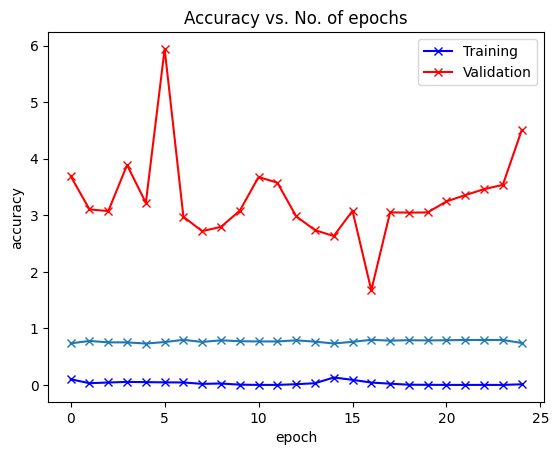

In [ ]:

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');



def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)
plot_accuracies(history)

                  precision    recall  f1-score   support

Aircraft Carrier       0.73      0.68      0.70        59
         Bulkers       0.47      0.85      0.60        97
  Container Ship       0.78      0.57      0.66        86
          Cruise       0.83      0.87      0.85        45
             DDG       0.83      0.43      0.57       102
       Submarine       0.82      0.71      0.76        66
             Tug       0.58      0.62      0.60        68

        accuracy                           0.66       523
       macro avg       0.72      0.67      0.68       523
    weighted avg       0.71      0.66      0.66       523

CPU times: user 3.42 s, sys: 369 ms, total: 3.79 s
Wall time: 1min 57s


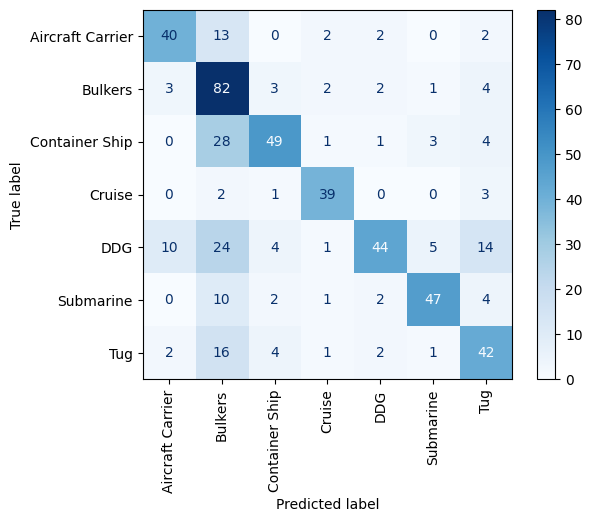

In [15]:
%%time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch

# Generate predictions and true labels
def get_predictions_and_labels(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Point Test DLoader
preds, labels = get_predictions_and_labels(model, test_dl)

# Confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")

# Classification report
print(classification_report(labels, preds, target_names=train_dataset.classes))

In [16]:
# Save o modelo treinado
torch.save(model.state_dict(), '/content/gdrive/MyDrive/ml_models/cnn_ships_alt.pth')
print("Model saved")

Model saved


In [ ]:
# Carrega o modelo salvo
loaded_model = CNN_ShipClassifier()
loaded_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ml_models/cnn_ships.pth'))
loaded_model = loaded_model.to(device)
model = loaded_model
print("Model loaded")

<ipython-input-16-03cf9980354e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/content/gdrive/MyDrive/datasets/cnn_ships.pth'))


Model loaded
